# HaitLab Primary課題 DeepLearning

In [14]:
# ライブラリのインポート(必ず実行してください。)
from __future__ import absolute_import, division, print_function, unicode_literals

import itertools
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.losses import categorical_crossentropy
%matplotlib inline

In [2]:
# 2.0.0のtensorflow kerasを想定しています(教材とバージョンが違うので注意)
tf.__version__

NameError: name 'tf' is not defined

---
## 第1問 深層学習（？/20点）
ここでは、CNNを用いて画像の分類に取り組みます。画像データとして、[CIFAR10](http://www.image-net.org)からダウンロードしたものの一部を使います。  
![](http://cdn-ak.f.st-hatena.com/images/fotolife/u/ultraist/20141108/20141108185409.png)

In [15]:
#！！！必ず実行すること！！！#
# コード改変禁止

#画像はカラー画像で、32×32
input_shape = (32, 32, 3)
# クラスの数は'airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'の10種類
num_classes = 10
cifar10_labels = np.array(['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'])

#データの読み込み
#本来なら
#from keras.datasets import cifar10
#(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#とする

with open('./data_light/x_train.pickle','rb') as f:
    X_train = pickle.load(f) 

with open('./data_light/y_train.pickle','rb') as f:
    y_train = pickle.load(f) 
    
with open('./data_light/x_test.pickle','rb') as f:
    X_test = pickle.load(f) 
    
with open('./data_light/y_test.pickle','rb') as f:
    y_test = pickle.load(f) 

"""
#ダミーデータ(データの読み込みが上手くいかなかったらこちらを使用してください)
X_train = np.full((50000, 32, 32, 3), 1, dtype='int8')
y_train = np.full(50000, 1)
X_test = np.full((10000, 32, 32, 3), 2, dtype='int8')
y_tset = np.full(10000, 1)
"""

# 一応宣言（今回のテストには影響ありません）
batch_size = 100
epochs = 32

print("X_train.shape:",X_train.shape)
print("X_test.shape: ",X_test.shape)
print("y_train.shape: ",y_train.shape)
print("y_test.shape: ",y_test.shape)

X_train.shape: (50, 32, 32, 3)
X_test.shape:  (50, 32, 32, 3)
y_train.shape:  (50, 1)
y_test.shape:  (50, 1)


In [18]:
y_train[0]

array([6], dtype=uint8)

本来はX_train:50000枚, X_test:10000枚のデータセットですが、流石に多いので今回は50枚を用います

In [6]:
#！！！必ず実行すること！！！#
# コード改変禁止
X_train = X_train[:50]
X_test = X_test[:50]
y_train = y_train[:50]
y_test = y_test[:50]

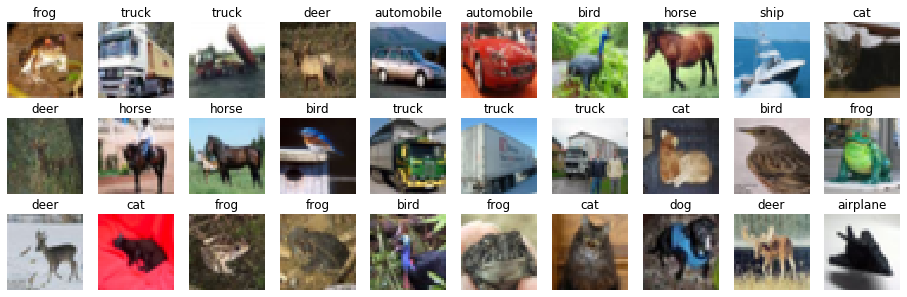

In [7]:
# trainの最初の30枚を表示
# コード改変禁止
def plot_head(X, y):
    plt.figure(figsize=(16,5))
    for index in range(30):
        plt.subplot(3, 10, index+1)
        plt.imshow(X[index])
        plt.axis('off')
        plt.title(cifar10_labels[y[index][0]])

plot_head(X_train, y_train)

---
学習データは一般に多ければ多いほど好ましいです。
まずはデータを水増ししていきます。

### 1) img(画像),x(右上のx座標),y(右上のy座標),px(pixel幅)を引数にとり、(x, y),(x+px, y),(x,y+px),(x+px, y+px)を四隅としてcropした後に、縦32pixel$\times$横32pixelに拡大した画像を返すcropping関数を定義してください。（2点）

In [8]:
def cropping(img, x, y, px):
    #(x, y),(x+px, y),(x,y+px),(x+px, y+px)を四隅としてcrop　(1点)
    cropped = img[x:x+px,y:y+px,:]
    #サイズを(32,32)に拡大　(1点)
    cropped = cv2.resize(cropped, (32, 32))
    return cropped

### 2) 画像を引数にとり、左右反転した画像を返すfrip関数を定義してください。（1点）

In [9]:
def flip(img):
    #左右反転　(1点)
    flipped = cv2.flip(img, 1)
    return flipped                                            

今定義した関数をまとめて前処理をする関数として定義し、実行します。

In [10]:
#！！！必ず実行すること！！！#
def preprocess(X, y):
    new_X = np.ndarray((0, 32,32, 3),dtype=np.uint8)
    new_y = np.ndarray((0),dtype=int)
    for index, img in enumerate(X):
        
        #crop & flip
        for i, j in itertools.product(range(3), range(3)):
            cropped = cropping(img, i*4, j*4, 24)
            flipped = flip(cropped)
        
            new_X = np.concatenate([new_X, cropped.reshape(1,32,32,3), flipped.reshape(1,32,32,3)],axis=0)
            new_y = np.concatenate([new_y, y[index], y[index]],axis=0)
    
    #シャッフル
    cnt = new_X.shape[0]
    
    shuffle_array = np.arange(cnt)
    np.random.shuffle(shuffle_array)
    
    new_X = new_X[shuffle_array]
    new_y = new_y[shuffle_array]
    
    new_y = new_y.reshape(-1, 1)
            
    return new_X, new_y

X_train.shape: (900, 32, 32, 3)
X_test.shape:  (50, 32, 32, 3)
y_train.shape:  (900, 1)
y_test.shape:  (50, 1)


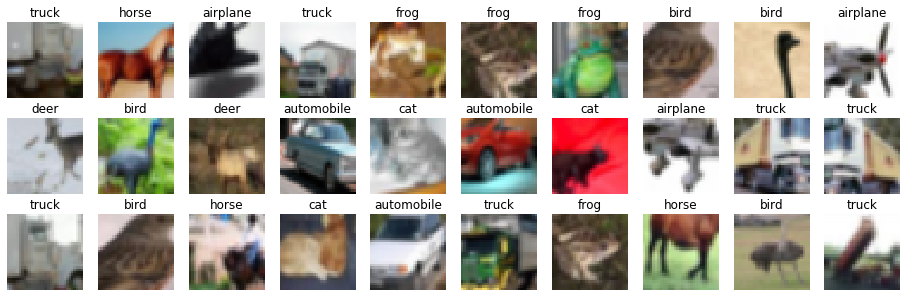

In [11]:
#！！！必ず実行すること！！！#（実行は1度だけにしてください。）
# 2回実行した時は、notebookをリセットし、再度実行し直すこと。
X_train, y_train = preprocess(X_train, y_train)
print("X_train.shape:",X_train.shape)
print("X_test.shape: ",X_test.shape)
print("y_train.shape: ",y_train.shape)
print("y_test.shape: ",y_test.shape)
plot_head(X_train, y_train)

これで画像の枚数を18倍（croppingで9倍、flipで2倍）に増やすことができました

In [12]:
y_train[0]

array([9])

### 3) Kerasが処理できる数値型に X_train と X_test を変換し、その後正規化を施してください（2点）

In [10]:
# Kerasが処理できる数値型にX_trainとX_testを変換　（1点）
# わかりません
# print(X_train[0,0])
X_train.astype("float32")
X_test.astype("float32")
# print(X_train[0,0])

# 正規化　（１点）
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
print(y_test.shape)

(50, 1)


### 4) 正解ラベル(y_trainとy_test)をOne-Hot表現に直してください。（1点）

In [12]:
# 正解ラベル(y_trainとy_test)をOne-Hot表現に変換　（1点）
# y_train = np.identity(10)[y_train].astype('i')
# y_test = np.identity(10)[y_test].astype('i')
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print("y_train.shape: ",y_train.shape)
print("y_test.shape: ",y_test.shape)

y_train.shape:  (900, 10)
y_test.shape:  (50, 10)


![](https://aistdcontents.blob.core.windows.net/image/deep_image.png)

### 5)  上図を参考にしながら、画像の分類予測を行うようなmodelを構築するコードを完成させてください。（7点）

In [13]:
# モデルの定義(7点)
model = Sequential()

## ２次元畳み込み層１ （2点）
model.add(Conv2D(filters=32, activation='relu', input_shape=input_shape, kernel_size=(3, 3), strides=(1, 1), padding='same'))

## ２次元畳み込み層２ （1点）
model.add(Conv2D(filters=64, activation='relu', kernel_size=(3, 3), strides=(1, 1), padding='same'))

## maxプーリング層 （1点）
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
## 全結合層１ （2点）
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.50))

## 全結合層２ （1点）
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
____

### 6)損失関数をimportして空欄を埋め、modelをコンパイルしてください（1点）

In [14]:
# コンパイル(1点)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(), 
              metrics=['accuracy'])

### 7)学習結果をhistに返してください。(2点)

In [15]:
#学習を行う(1点)
hist = model.fit(X_train,
                 y_train,
                 epochs=epochs,
                 validation_data=(X_test, y_test),
                 verbose=1,
                 batch_size=batch_size)

Train on 900 samples, validate on 50 samples
Epoch 1/32
900/900 [==============================] - 1s 2ms/sample - loss: 2.2577 - acc: 0.1267 - val_loss: 2.3483 - val_acc: 0.0200
Epoch 2/32
900/900 [==============================] - 1s 1ms/sample - loss: 2.0719 - acc: 0.2122 - val_loss: 2.4730 - val_acc: 0.1400
Epoch 3/32
900/900 [==============================] - 1s 1ms/sample - loss: 1.9004 - acc: 0.3122 - val_loss: 2.4210 - val_acc: 0.2000
Epoch 4/32
900/900 [==============================] - 1s 1ms/sample - loss: 1.7521 - acc: 0.3678 - val_loss: 2.2959 - val_acc: 0.3200
Epoch 5/32
900/900 [==============================] - 1s 2ms/sample - loss: 1.5815 - acc: 0.4567 - val_loss: 2.7297 - val_acc: 0.2000
Epoch 6/32
900/900 [==============================] - 1s 1ms/sample - loss: 1.4304 - acc: 0.5122 - val_loss: 2.5903 - val_acc: 0.2000
Epoch 7/32
900/900 [==============================] - 1s 1ms/sample - loss: 1.2224 - acc: 0.5922 - val_loss: 2.7810 - val_acc: 0.2400
Epoch 8/32
900/90

### 8)損失と精度のグラフをプロットしてください。(2点)

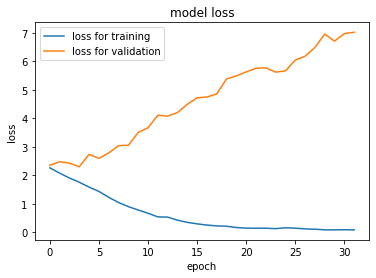

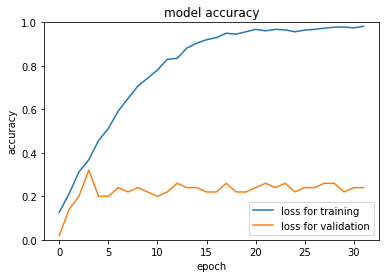

In [17]:
## 損失関数のグラフ(1点)
def plot_history_loss(hist):
    # hist.historyに辞書型で損失値や精度が入っているので取得して表示
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    
    #matplotlibの細かい設定
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    
    plt.show()
    

##　精度のグラフ(1点)
## tf2.0では'acc'ではなく'accuracy'なので注意
def plot_history_acc(hist):
    plt.plot(hist.history['acc'],label="loss for training")
    plt.plot(hist.history['val_acc'],label="loss for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.show()

plot_history_loss(hist)
plot_history_acc(hist)

### 9) プロットしたグラフから学習の傾向を分析してください。(簡単で構いません。) (1点)

#### 解答欄
訓練用のデータに、適し過ぎている。
訓練用データ以外のデータの対応ができていない。
過学習が起きている。

### 10) 精度を向上するためにどのような工夫が必要でしょうか? (1点)

#### 解答欄
データを増やす。
層を深くする。

### 11)学習結果を可視化して下さい。(5点)
tensorflowチュートリアルのこのサイトが参考になります。(変数の型に注意)  
https://www.tensorflow.org/tutorials/keras/classification?hl=ja

In [39]:
## 画像をプロットする関数(2点)
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if (predicted_label == true_label).any():
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(cifar10_labels[predicted_label],
                                    100*np.max(predictions_array),
                                    cifar10_labels[true_label[0].argmax()]), # あってない
                                    color=color)

## 正答率のグラフの表示する関数(2点)
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label[0].argmax()].set_color('blue') # あってない

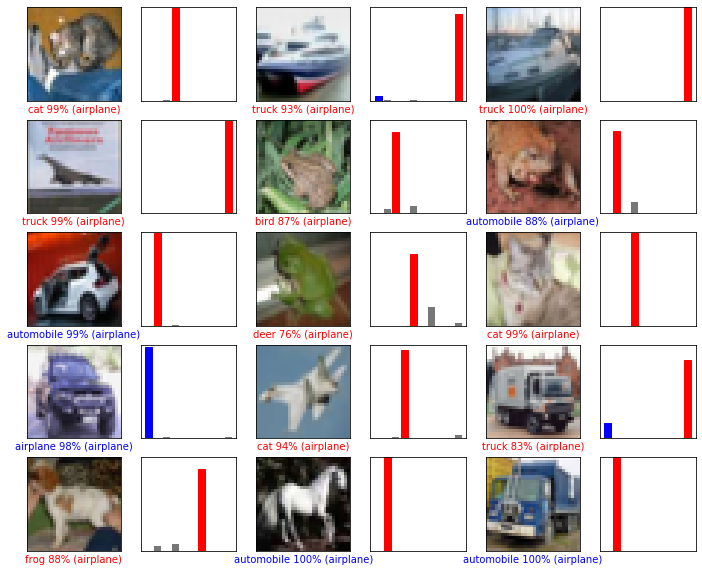

In [40]:
# 改変禁止
# X個のテスト画像、予測されたラベル、正解ラベルを表示します。
# 正しい予測は青で、間違った予測は赤で表示しています。
# 正しくじっこうで
predictions = model.predict(X_test)
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, y_test)
plt.show()